<a href="https://colab.research.google.com/github/punitarani/MAT-494/blob/master/2.2%20Probability%20Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.2 Probability Distribution
______________________________
### Key Concepts:
* Types of Distributions
* Conditional Probability
* Normal Distribution
* Skew and Kurtosis

In [1]:
from functools import partial
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.stats as stats
from sklearn import datasets

In [2]:
plt.style.use("seaborn-notebook")

## Load California Housing Dataset

This dataset was derived from the 1990 U.S. census, using one row per census block group.
A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data.

<br>

### Columns
**MedInc**
Median income in block group

**HouseAge**
Median house age in block group

**AveRooms**
Average number of rooms per household

**AveBedrms**
Average number of bedrooms per household

**Population**
Block group population

**AveOccup**
Average number of household members

**Latitude**
Block group latitude

**Longitude**
Block group longitude

In [3]:
# California Housing Dataset
ch_dataset = datasets.fetch_california_housing(download_if_missing=False, as_frame=True)

# California Housing DataFrame
chdf = ch_dataset.data

# Print DataFrame Shape, Columns and DataTypes
print("DataFrame Size: ", chdf.shape)
print("\nColumns and Data Types:\n", chdf.dtypes)

DataFrame Size:  (20640, 8)

Columns and Data Types:
 MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object


## Types of Distributions

### Continuous

Values comprise a single interval on a number line or a union of disjoint intervals.
Continuous Values are usually **measured**.

**Examples**: MedInc, Longitude, Latitude


### Discrete

Values constitute a finite set or listed in an infinite sequence.
Discrete Values are usually **counted**.

**Examples**: HouseAge, AveRooms, AveBedrms, Population, AveOccup

### Visualize

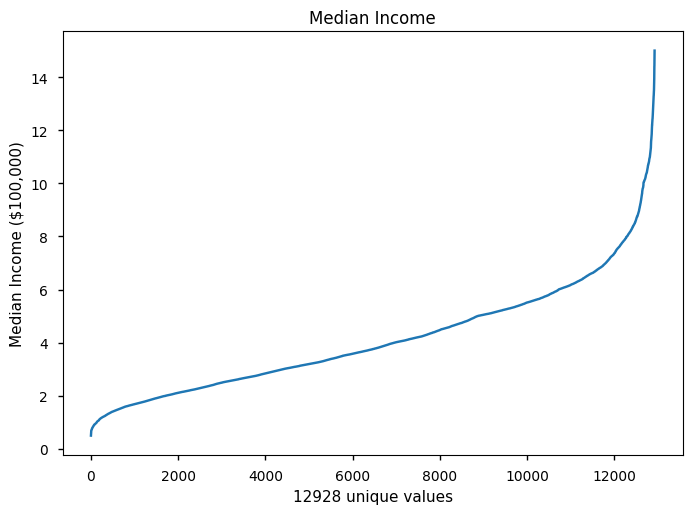

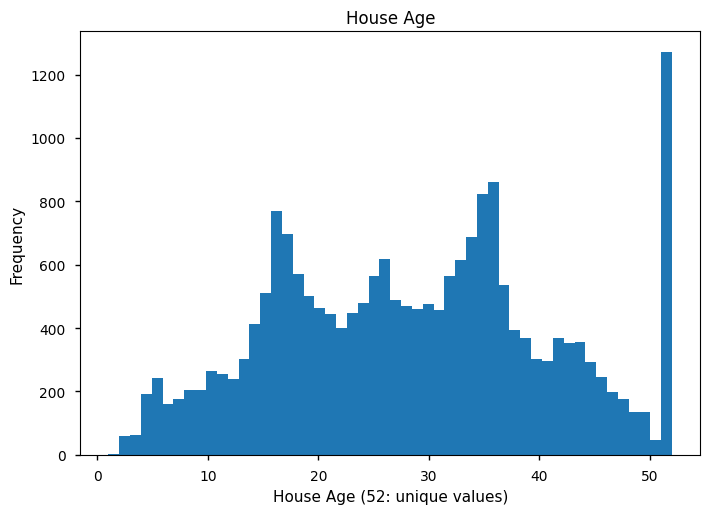

In [4]:
# Get unique MedInc values
MedInc_vals = chdf["MedInc"].unique()

# Plot MedInc values
plt.figure()
plt.plot(sorted(MedInc_vals))
plt.title("Median Income")
plt.xlabel(f"{len(MedInc_vals)} unique values")
plt.ylabel(f"Median Income ($100,000)")
plt.show()


# Get unique HouseAge values
HouseAge_vals = chdf["HouseAge"].unique()

# Plot HouseAge values
plt.figure()
plt.hist(chdf["HouseAge"], bins=len(HouseAge_vals))
plt.title("House Age")
plt.xlabel(f"House Age ({len(HouseAge_vals)}: unique values)")
plt.ylabel("Frequency")
plt.show()

## Conditional Probability

In [5]:
prob_HouseAge_less_20 = chdf[chdf["HouseAge"] < 20].shape[0] / chdf.shape[0]
prob_AveRooms_more_5 = chdf[chdf["AveRooms"] > 5].shape[0] / chdf.shape[0]
prob_hal_20_rm_5 = chdf[(chdf["HouseAge"] < 20) & (chdf["AveRooms"] > 5)].shape[0] / chdf.shape[0]

print(f"Probability a House is less than 20 years old: {prob_HouseAge_less_20*100:.2f}%")
print(f"Probability a House has more than 5 rooms: {prob_AveRooms_more_5*100:.2f}%")
print(f"Probability a House is less than 20 Y/O and more than 5 rooms: {prob_hal_20_rm_5*100:.2f}%")

prob_hal_20_or_rm_5 = prob_HouseAge_less_20 + prob_AveRooms_more_5 - prob_hal_20_rm_5
print(f"Probability a House is less than 20 Y/O or more than 5 rooms: {prob_hal_20_or_rm_5*100:.2f}%")

prob_hal_20_then_rm_5 = prob_hal_20_rm_5 / prob_AveRooms_more_5
print(f"Probability a House is less than 20 Y/O if it has more than 5 rooms: {prob_hal_20_then_rm_5*100:.2f}%")

Probability a House is less than 20 years old: 28.24%
Probability a House has more than 5 rooms: 57.70%
Probability a House is less than 20 Y/O and more than 5 rooms: 19.81%
Probability a House is less than 20 Y/O or more than 5 rooms: 66.13%
Probability a House is less than 20 Y/O if it has more than 5 rooms: 34.32%


## The Normal Distribution

Probability Distribution Function:
$ f(x; \mu, \sigma) = \frac {1} {\sqrt {2 \pi} \sigma } e ^ {\frac {- (x - \mu) ^2} {2 \sigma ^2}} $

where:
* $\mu$ is the Mean
* $\sigma$ is the Standard Deviation

Observing the distribution of Average Occupancy rates,
we can see that it is a slightly right-skewed normally distribution.

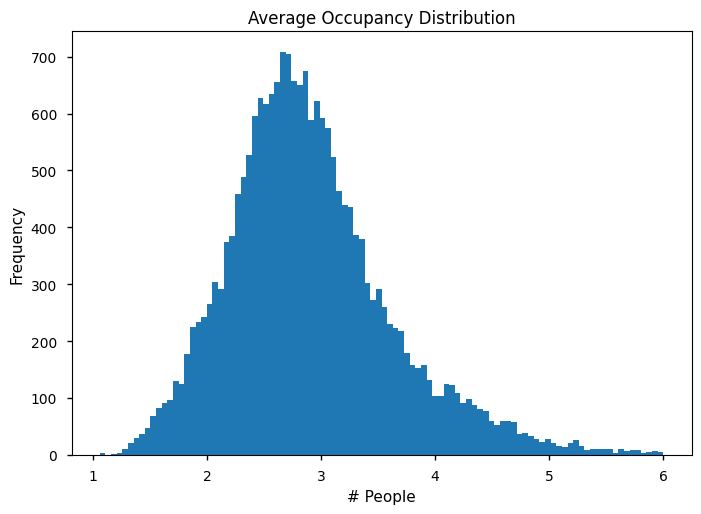

In [6]:
# AveRooms_vals = chdf["AveRooms"].unique()
# Filter to between 0 and 6 by removing outliers
aoa, aob = 1, 6
AveOccup_vals = chdf[chdf["AveOccup"].between(aoa, aob)]["AveOccup"]

plt.figure()
plt.hist(AveOccup_vals, bins=100)
plt.title("Average Occupancy Distribution")
plt.xlabel("# People")
plt.ylabel("Frequency")
plt.show()

### Modeling the AveOccup Distribution

In [7]:
# Computing the mean and standard deviation
AveOccup_mean = AveOccup_vals.mean()
AveOccup_std = AveOccup_vals.std()
print(f"AveOccup has a mean of {AveOccup_mean:.2f} with a standard deviation of {AveOccup_std:.4f}.")

AveOccup has a mean of 2.90 with a standard deviation of 0.7171.


In [8]:
def solve_norm_pdf(u, sigma, val):
    """
    Solve the Normal Distribution PDF
    :param u: Mean of Data
    :param sigma: Standard Deviation of Data
    :param val: Value to solve
    :return: Probability of val to occur in data of given mean and deviation
    """
    denom = math.sqrt(2 * math.pi) * sigma

    exp_pow = - ((val - u) ** 2) / (2 * (sigma**2))
    exp = math.pow(math.e, exp_pow)

    return 1 / denom * exp

In [9]:
def solve_norm_cdf(u, sigma, a=-3, b=3):
    """
    Solve the Normal Distribution CDF
    :param u: Mean of Data
    :param sigma: Standard Deviation of Data
    :param a: Left bound x value. (Default: -3)
    :param b: Right bound x value. (Default: 3)
    :return: CDF of
    """
    pdf_func = partial(solve_norm_pdf, u, sigma)
    return integrate.quad(pdf_func, a, b)[0]

In [10]:
print("Computed Probability (pdf) of Average Occupancies:")
print(f"\t1: {solve_norm_pdf(AveOccup_mean, AveOccup_std, 1)*100:.2f}%")
print(f"\t2: {solve_norm_pdf(AveOccup_mean, AveOccup_std, 2)*100:.2f}%")
print(f"\t3: {solve_norm_pdf(AveOccup_mean, AveOccup_std, 3)*100:.2f}%")
print(f"\t4: {solve_norm_pdf(AveOccup_mean, AveOccup_std, 4)*100:.2f}%")
print(f"\t5: {solve_norm_pdf(AveOccup_mean, AveOccup_std, 5)*100:.2f}%")
print(f"\t6: {solve_norm_pdf(AveOccup_mean, AveOccup_std, 6)*100:.3f}%")

Computed Probability (pdf) of Average Occupancies:
	1: 1.65%
	2: 25.18%
	3: 55.12%
	4: 17.26%
	5: 0.77%
	6: 0.005%


In [11]:
print("Cumulative Probability (cdf) of Average Occupancies:")
print(f"\t1: {solve_norm_cdf(AveOccup_mean, AveOccup_std, b=1)*100:.2f}%")
print(f"\t2: {solve_norm_cdf(AveOccup_mean, AveOccup_std, b=2)*100:.2f}%")
print(f"\t3: {solve_norm_cdf(AveOccup_mean, AveOccup_std, b=3)*100:.2f}%")
print(f"\t4: {solve_norm_cdf(AveOccup_mean, AveOccup_std, b=4)*100:.2f}%")
print(f"\t5: {solve_norm_cdf(AveOccup_mean, AveOccup_std, b=5)*100:.2f}%")
print(f"\t6: {solve_norm_cdf(AveOccup_mean, AveOccup_std, b=6)*100:.2f}%")

Cumulative Probability (cdf) of Average Occupancies:
	1: 0.40%
	2: 10.40%
	3: 55.39%
	4: 93.70%
	5: 99.83%
	6: 100.00%


#### Verify by plotting against Real Data

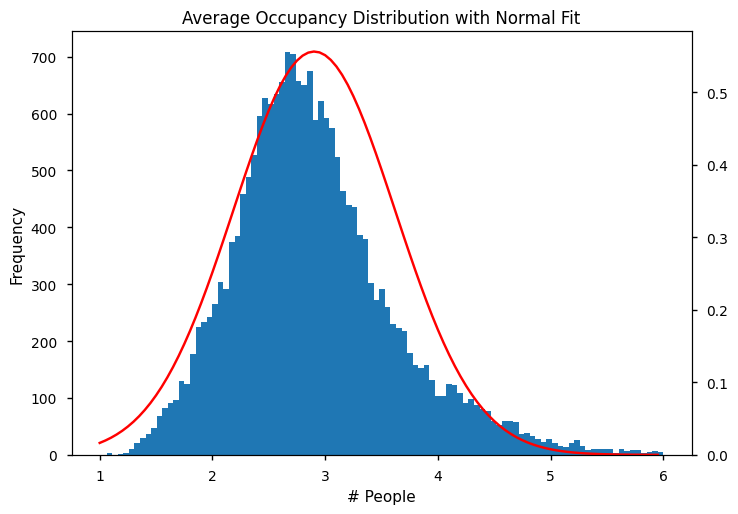

In [12]:
AveOccup_vals_probs = [solve_norm_pdf(AveOccup_mean, AveOccup_std, val*(aob-aoa)/100+1) for val in range(0, 100)]

ao_fig, ao_ax = plt.subplots()

ao_ax.hist(AveOccup_vals, bins=100)

ao_ax2 = ao_ax.twinx()
ao_ax2.plot([val*(aob-aoa)/100+1 for val in range(0, 100)], AveOccup_vals_probs, color="red")
ao_ax2.set_ylim(bottom=0)

ao_ax.set_title("Average Occupancy Distribution with Normal Fit")
ao_ax.set_xlabel("# People")
ao_ax.set_ylabel("Frequency")
plt.show()

### Skew and Kurtosis

Used to enhance the location and variability of a distribution


#### Skew

Measure of (lack of) symmetry of a distribution. Identify when side the mean is leaning towards.

$ skew = \frac {\sum (x _i - \bar x)^3} {(n - 1) * \sigma ^3} $


#### Kurtosis

Measure the weight of the tails. Identify if the data is outlier (tail) heavy.

**Fisher's Definition**

$ kurtosis = \frac {\sum (x _i - \bar x) ^4} {n \sigma ^ 4} - 3$


In [13]:
def get_skew(data):
    """
    Calculate the Skew
    :param data: Data
    :return: Skew of the Data
    """
    return np.sum((data - np.mean(data)) ** 3) / (len(data) * (np.std(data) ** 3))

In [14]:
def get_kurtosis(data):
    """
    Calculate the Kurtosis
    :param data: Data
    :return: Kurtosis of the Data
    """
    return np.sum((data - np.mean(data)) ** 4) / (len(data) * (np.var(data) ** 2)) - 3

In [15]:
AveOccup_skew = get_skew(AveOccup_vals)
AveOccup_kurt = get_kurtosis(AveOccup_vals)

print(f"AveOccup Skew:     {AveOccup_skew:.3f}")
print(f"AveOccup Kurtosis: {AveOccup_kurt:.3f}")

AveOccup Skew:     0.798
AveOccup Kurtosis: 1.085


In [16]:
print("Verify with SciPy")
print(f"AveOccup Skew:     {stats.skew(AveOccup_vals):.3f}")
print(f"AveOccup Kurtosis: {stats.kurtosis(AveOccup_vals):.3f}")

Verify with SciPy
AveOccup Skew:     0.798
AveOccup Kurtosis: 1.085


## Normal Distribution with Skew


In [17]:
def solve_skewed_norm_pdf(u, sigma, val, skew=0):
    """
    Solve the Skewed Normal Distribution PDF
    :param u: Mean of Data
    :param sigma: Standard Deviation of Data
    :param val: Value to solve
    :param skew: Skewness of Data (Default = 0)
    :return: Probability of val to occur in data of given mean and deviation
    """
    E = -sigma
    W = 1
    A = skew

    pdf_val = (val - E) / W
    cdf_val = A * pdf_val

    return 2 * solve_norm_pdf(u, sigma, pdf_val) * solve_norm_cdf(u, sigma, u-4*sigma, cdf_val)

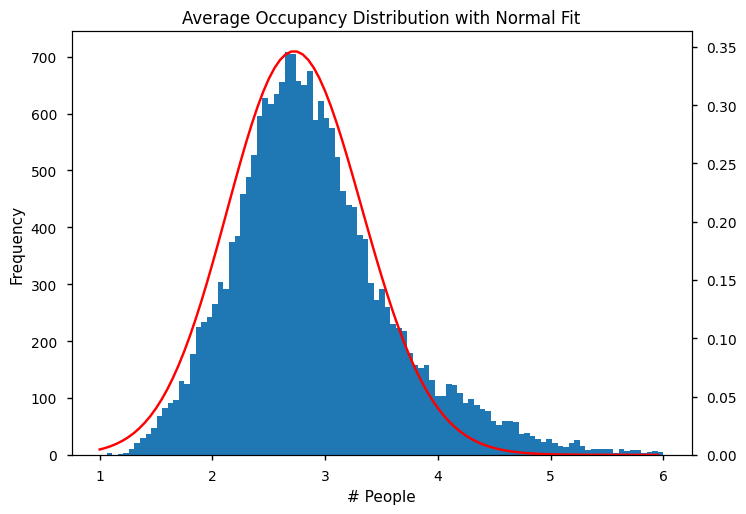

In [18]:
AveOccup_skewed_vals_probs = [solve_skewed_norm_pdf(AveOccup_mean, AveOccup_std, val*(aob-aoa)/100+1, skew=AveOccup_skew) for val in range(0, 100)]

aos_fig, aos_ax = plt.subplots()

aos_ax.hist(AveOccup_vals, bins=100)

aos_ax2 = aos_ax.twinx()
aos_ax2.plot([val*(aob-aoa)/100+1 for val in range(0, 100)], AveOccup_skewed_vals_probs, color="red")
aos_ax2.set_ylim(bottom=0)

aos_ax.set_title("Average Occupancy Distribution with Normal Fit")
aos_ax.set_xlabel("# People")
aos_ax.set_ylabel("Frequency")
plt.show()

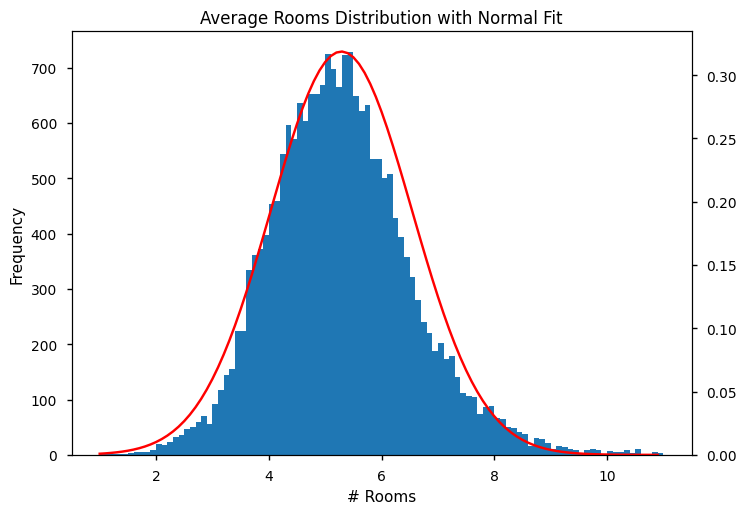

In [19]:
ara, arb = 1, 11

AveRooms_vals = chdf[chdf["AveRooms"].between(ara, arb)]["AveRooms"]
AveRooms_mean = np.mean(AveRooms_vals)
AveRooms_std = np.std(AveRooms_vals)
AveRooms_skew = np.std(AveRooms_vals)

AveRooms_skewed_vals_probs = [
    solve_norm_pdf(AveRooms_mean, AveRooms_std, val*(arb-ara)/100+1)
    for val in range(0, 100)
]

ars_fig, ars_ax = plt.subplots()

ars_ax.hist(AveRooms_vals, bins=100)

ars_ax2 = ars_ax.twinx()
ars_ax2.plot([val*(arb-ara)/100+1 for val in range(0, 100)], AveRooms_skewed_vals_probs, color="red")
ars_ax2.set_ylim(bottom=0)

ars_ax.set_title("Average Rooms Distribution with Normal Fit")
ars_ax.set_xlabel("# Rooms")
ars_ax.set_ylabel("Frequency")
plt.show()